In [135]:
## Try to plot the Schechter function
## import packages, need healpy to plot skymaps
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import math
import h5py
import statistics
from scipy.integrate import quad
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy import units as u

In [180]:
alpha = -1.07
H_0 = 70
mag_star_b = -19.7 + 5*np.log(H_0/100)
c = 3e5 # km/s
pc = 3.086e16 # meters
Mpc = 1e6 * pc # meters
phi_star = 60
min_mag = -25
max_mag = -12.2 + 5*np.log(H_0/100)
min_D_L = 10
max_D_L = 100
min_z = 0.5
max_z = 1.5
app_threshold = 0

In [181]:
def luminosity_distance(z, H0):
    # z (float): The redshift.
    # H0 (float): The Hubble constant in units of km/s/Mpc.
    # The luminosity distance in units of Mpc.
 
    from scipy.integrate import quad
    from astropy.cosmology import FlatLambdaCDM
    
    # define the cosmology using the FlatLambdaCDM model from Astropy
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    
    # define the integrand function
    def integrand(x):
        return 1.0 / np.sqrt(cosmo.Om(z) * (1.0 + x)**3 + (1.0 - cosmo.Om(z)))
    
    # integrate the function from 0 to z
    integral, error = quad(integrand, 0, z)
    
    # calculate the luminosity distance using the cosmological parameters
    DL = (1.0 + z) * cosmo.luminosity_distance(z).value
    
    return DL

In [182]:
def redshift_from_distance(DL, H0):
    '''
    Calculates the redshift for a given luminosity distance and Hubble constant.
    
    Args:
        DL (float): The luminosity distance in units of Mpc.
        H0 (float): The Hubble constant in units of km/s/Mpc.
        
    Returns:
        float: The redshift.
    '''
    # define the cosmology using the FlatLambdaCDM model from Astropy
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    
    z = z_at_value(cosmo.luminosity_distance, DL * u.Mpc, zmax=10)
    
    return z

In [183]:
# first for the Schechter function:
mag = np.linspace(min_mag,max_mag,100)
n_M = 0.4*np.log(10)*phi_star*(10**(-0.4*(mag_star_b - mag)))**(alpha+1)*np.exp(-10**(0.4*(mag_star_b - mag)))



Text(0.5, 1.0, 'Galaxy distribution')

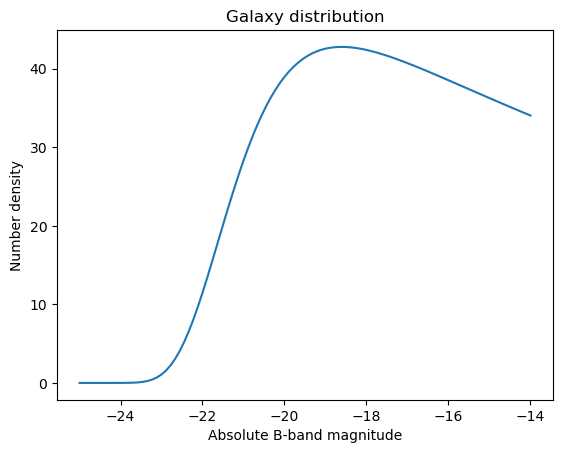

In [184]:
plt.plot(mag,n_M)
plt.xlabel('Absolute B-band magnitude')
plt.ylabel('Number density')
plt.title('Galaxy distribution')

In [185]:

# apparent b band threshold

'''
# calculate the maxium and minimum luminosity distance 
E = lambda z: np.sqrt(0.3*(1+z)**3 + 0.7)
min_D_L = c/H0 * (1+min_z) * quad(lambda z: 1/E(z), 0, min_z)[0]
max_D_L = c/H0 * (1+max_z) * quad(lambda z: 1/E(z), 0, max_z)[0]
D_L_list = np.linspace(min_D_L,max_D_L,num=50)
'''
D_L_list = np.linspace(min_D_L,max_D_L,num=50)
comp = np.ones(len(D_L_list))
N = np.zeros(len(D_L_list))
for i in range(len(D_L_list)): # we essentially treat the space as sphere shells
    D_L = D_L_list[i]
    # absolute b band threshold
    threshold = app_threshold - 5 * np.log10(D_L) - 25 
    if threshold<=min_mag: # empty GC scenario
        comp[i] = 0
        #print('1')
    else:
        maglist_GC = np.linspace(min_mag,threshold,num=100) # need better limitation
        maglist = np.linspace(min_mag,max_mag,num=100) # need better limitation
        delta_m_GC = abs(maglist_GC[0]-maglist_GC[1])
        delta_m = abs(maglist[0]-maglist[1])
        num_den_D_GC = 0 # number density of galaxies at distance D that are in the GC
        num_den_D = 0 # overall number density of galaxies at distance D
        for j in range(len(maglist_GC)):
            mag_temp = maglist_GC[j]
            n_M = 0.4*np.log(10)*phi_star*(10**(-0.4*(mag_star_b - mag_temp)))**(alpha+1)*np.exp(-10**(0.4*(mag_star_b - mag_temp)))
            num_den_D_GC += delta_m_GC*n_M # The number density of all magnitudes
            #print(mag_temp)
        for j in range(len(maglist)):
            mag_temp  = maglist[j]
            n_M = 0.4*np.log(10)*phi_star*(10**(-0.4*(mag_star_b - mag_temp)))**(alpha+1)*np.exp(-10**(0.4*(mag_star_b - mag_temp)))
            num_den_D += delta_m*n_M # The number density of all magnitudes
        comp[i] = num_den_D_GC/num_den_D

In [186]:
comp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5, 1.0, 'Galaxy catalogue completeness')

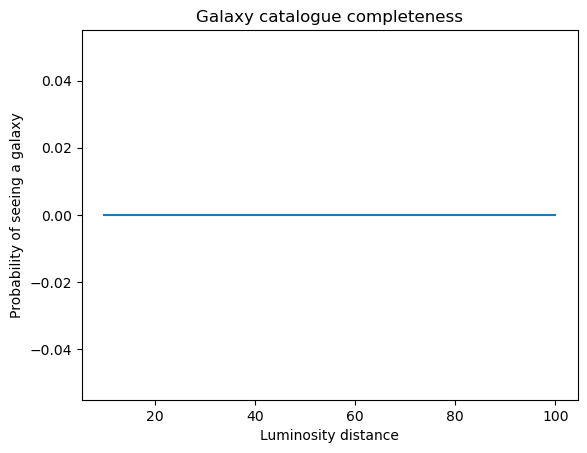

In [143]:
plt.plot(D_L_list,comp)
plt.xlabel('Luminosity distance')
plt.ylabel('Probability of seeing a galaxy')
plt.title('Galaxy catalogue completeness')

Text(0.5, 1.0, 'Galaxy catalogue completeness')

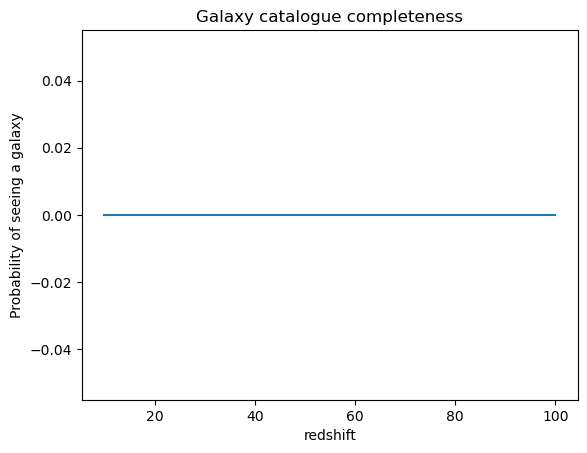

In [94]:
z = np.ones(len(D_L_list))
for i in range(len(D_L_list)):
    z[i] = redshift_from_distance(D_L_list[i], H_0)
    
plt.plot(D_L_list,comp)
plt.xlabel('redshift')
plt.ylabel('Probability of seeing a galaxy')
plt.title('Galaxy catalogue completeness')